In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
class BasicLightning(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad = False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad = False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad = False)
        
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad = False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad = False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad = False)
        
        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad = False)
        
    def forward(self, input):
        input_to_top_relu = input*self.w00+self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output*self.w01
        
        input_to_bottom_relu = input*self.w10+self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output *self.w11
        
        input_to_final_relu = (scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias)
        
        output = F.relu(input_to_final_relu)
        return output

In [6]:
input_doses = torch.linspace(start = 0, end = 1, steps = 11)
input_doses

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

In [7]:
model = BasicLightning()
output_values = model(input_doses)
output_values

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0100, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

Text(0, 0.5, 'effect')

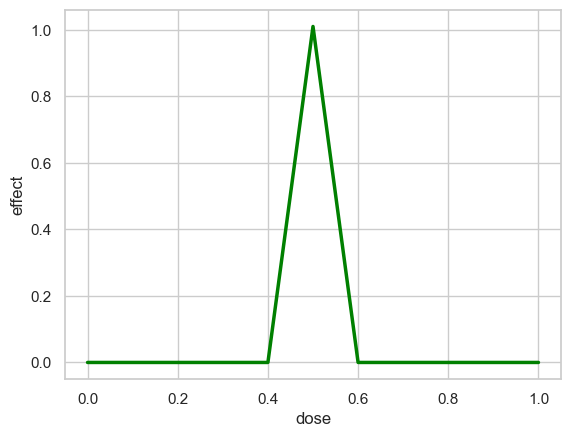

In [8]:
sns.set(style = "whitegrid")
sns.lineplot(x = input_doses,
            y= output_values,
            color = 'green',
            linewidth=2.5)
plt.xlabel('dose')
plt.ylabel('effect')

In [29]:
class BasicLightningTrain(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad = False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad = False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad = False)
        
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad = False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad = False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad = False)
        
        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad = True)
        self.learning_rate = 0.01
        
    def forward(self, input):
        input_to_top_relu = input*self.w00+self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output*self.w01
        
        input_to_bottom_relu = input*self.w10+self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output *self.w11
        
        input_to_final_relu = (scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias)
        
        output = F.relu(input_to_final_relu)
        return output
    
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = F.mse_loss(output_i, label_i)
        
        return loss

In [32]:
inputs = torch.tensor([0.,0.5,1.])
labels = torch.tensor([0.,1.,0.])

dataset = TensorDataset(inputs, labels)
dataloaders = DataLoader(dataset)

In [34]:
model = BasicLightningTrain()
trainer = L.Trainer(max_epochs = 34, accelerator="auto", devices= "auto")
tuner = L.pytorch.tuner.Tuner(trainer)
lr_find_results = tuner.lr_find(model,
                                                        train_dataloaders = dataloaders,
                                                        min_lr = 0.0001,  # decrease min_lr
                                                        max_lr = 0.1,  # decrease max_lr
                                                        num_training = 100,  # increase num_training
                                                        early_stop_threshold = None,  # increase early_stop_threshold
                                                        )

new_lr = lr_find_results.suggestion()
print(new_lr)
model.learning_rate = new_lr

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00021379620895022324
Restoring states from the checkpoint path at d:\University\2023-2024\HK1\DS105\Final\.lr_find_961e08e6-e9aa-4dc3-8d63-0c58a1631dcf.ckpt
Restored all states from the checkpoint at d:\University\2023-2024\HK1\DS105\Final\.lr_find_961e08e6-e9aa-4dc3-8d63-0c58a1631dcf.ckpt


0.00021379620895022324


In [31]:
trainer.fit(model=model, train_dataloaders = dataloaders)
print(model.final_bias.data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params
--------------------------------------
  | other params | n/a  | 7     
--------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=34` reached.


tensor(-12.2700)
